In [139]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats
import scipy as sp
import scipy.stats as stats


import os
#Блок в рамках которого импотряться графики
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure
sns.set_style('darkgrid')


#Блок в рамках которого импотряться статистические пакеты
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.diagnostic import compare_encompassing 

# Содержание работы

[Обработка и получение данных](#Introduction)
#### Выполнение заданий:
1. [Задание 1](#subparagraph1) -  Оценка линейной модели
2. [Задание 2](#subparagraph2) - Оценка полулогорифмической модели
3. [Задание 3](#subparagraph3) - Оценка линейной в логарифмах модели
4. [Задание 4](#subparagraph4) - Выбор модели (Тест Бокса-Кокса с преообразованием Зарембки)
5. [Задание 5](#subparagraph5) - Тестирование различия в ЗП (Тест Чоу)
6. [Задание 6](#subparagraph6) - Тестирование наличие выборосов (DFbettas, Leverage, Dffits)
7. [Задание 7](#subparagraph7) - Поиск мультиколлиниарности (VIF)
8. [Задание 8](#subparagraph8) - Применение PCA
9. [Задание 9](#subparagraph9) - Построение графика остатки-прогнозы
10. [Задание 10](#subparagraph10) - Тестирование гетероскедостичности (Тест Уйта, Голдфелда — Куандта, Бройша — Пагана
11. [Задание 11](#subparagraph11) - Проведение Теста Рамсея
12. [Задание 12](#subparagraph12) - Оценка и сравнение модели
13. [Задание 13](#subparagraph13) - Предложение функциональных форм
14. [Задание 14](#subparagraph14) - Итоговая оценка модели

### 0. Предварительный EDA

In [2]:
cd "C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis\"

C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis


In [3]:
# # making "directoryback"
# os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [4]:
data = pd.read_csv('Data/PhonesDF_years.csv')
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,battery_type,disp_height,disp_width,oper_syst_type,oper_syst_vers,brand,year_of_release
245,Tecno Spark Plus K9,13999.0,3.8,48,147,6.0,5.0,16.0,2.0,3400.0,Li-Ion,1280.0,720.0,Android,7,Tecno,2017
500,LG V20 64 GB,599.0,4.1,58,14,5.7,5.0,64.0,4.0,3200.0,Li-Ion,2560.0,1440.0,Android,7,LG,2016
884,Apple iPhone 7 Plus 256 GB,43000.0,3.6,63,14,5.5,7.0,256.0,3.0,2900.0,Li-Ion,1920.0,1080.0,IOS,10,Apple,2016


In [5]:
# adding log price and PPI to dataset
data['log_price'] = np.log(data.price)
data['density'] = data.disp_height * data.disp_width / data.disp_diag**2

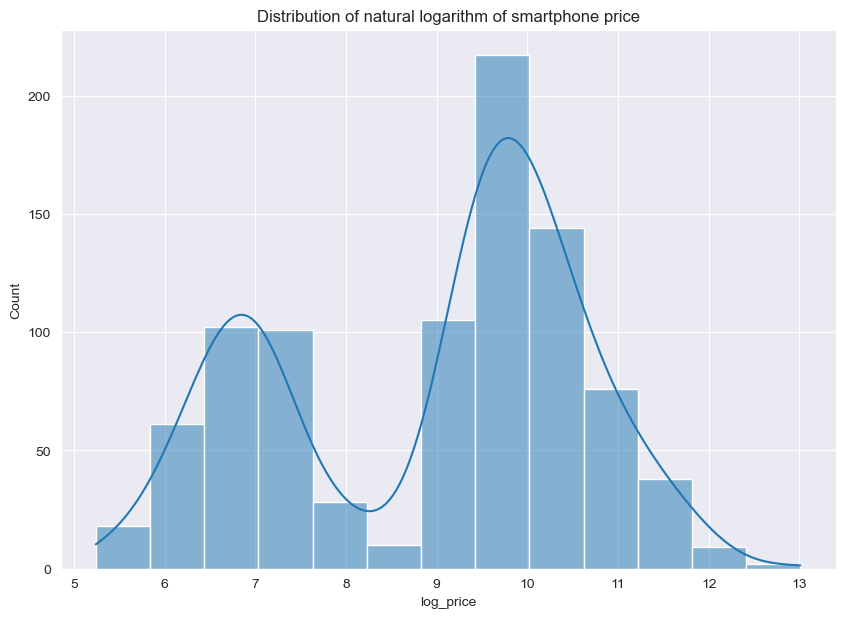

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что у нас получилось бимодальное распределение, где каждый колокол напомоминает нормальное распределение. Скорее всего, это связано с тем, что у нас в датасете есть много некорректно указанных цен (ошибка с порядком цены), так как в левой части распределения телефоны имеют цену ниже 2000 рублей, что выглядит неправдоподобно.

Избавимся от этих выбросов и построим новое распределение цены:

In [7]:
# correcting and saving data
data = data.loc[(data.price >= np.exp(8.3)) & (data.price < np.exp(12.5)), :].copy(deep=True)
data.to_csv('Data/PhonesDF_years_corrected.csv', index=False)

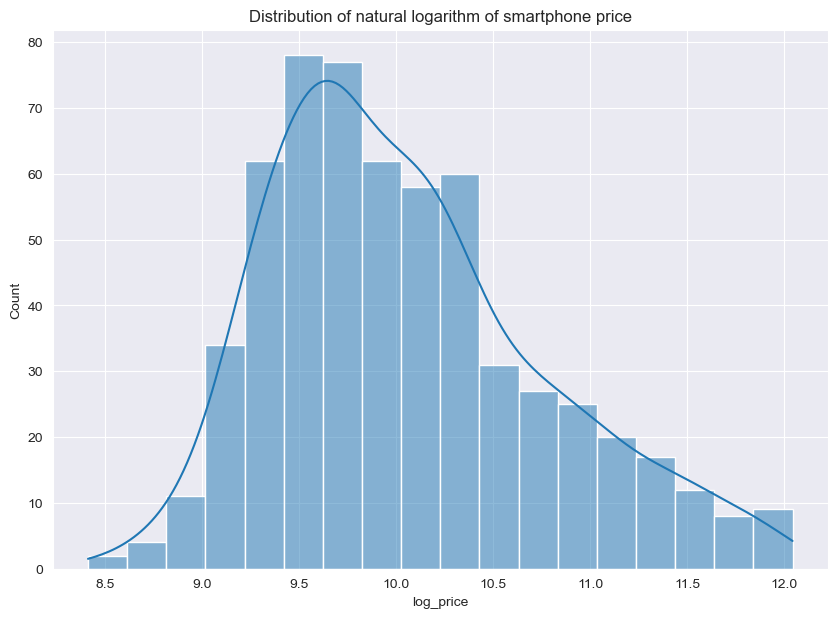

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что распределение логарифма цены имеет правостороннюю ассиметрию.

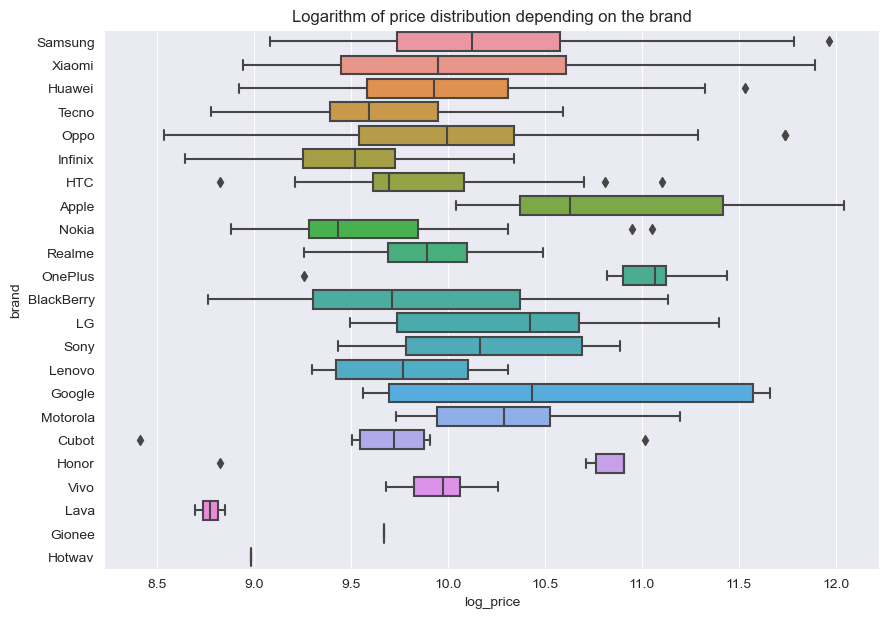

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=data, y='brand', x='log_price', ax=ax, order=list(data.brand.value_counts().index))
ax.set_title('Logarithm of price distribution depending on the brand');

Видно, что айфоны и смартфоны бренда Google сущестсвенно дороже, чем остальные.

Построим, как цена и ее логарифм зависит от числовых характеристик смартфона.

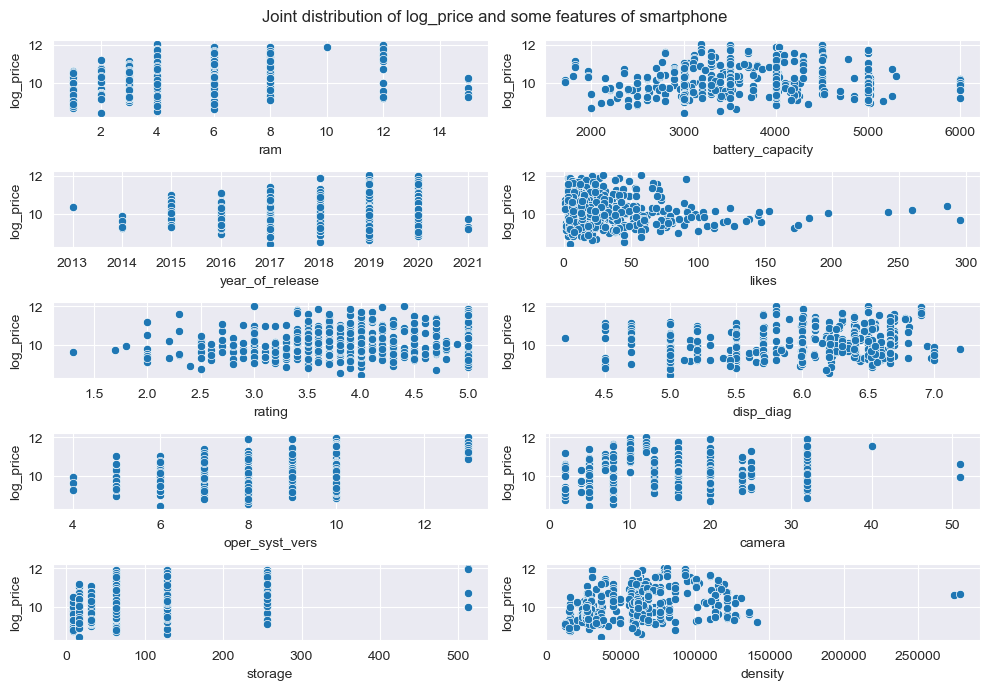

In [10]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='log_price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of log_price and some features of smartphone')
plt.tight_layout();

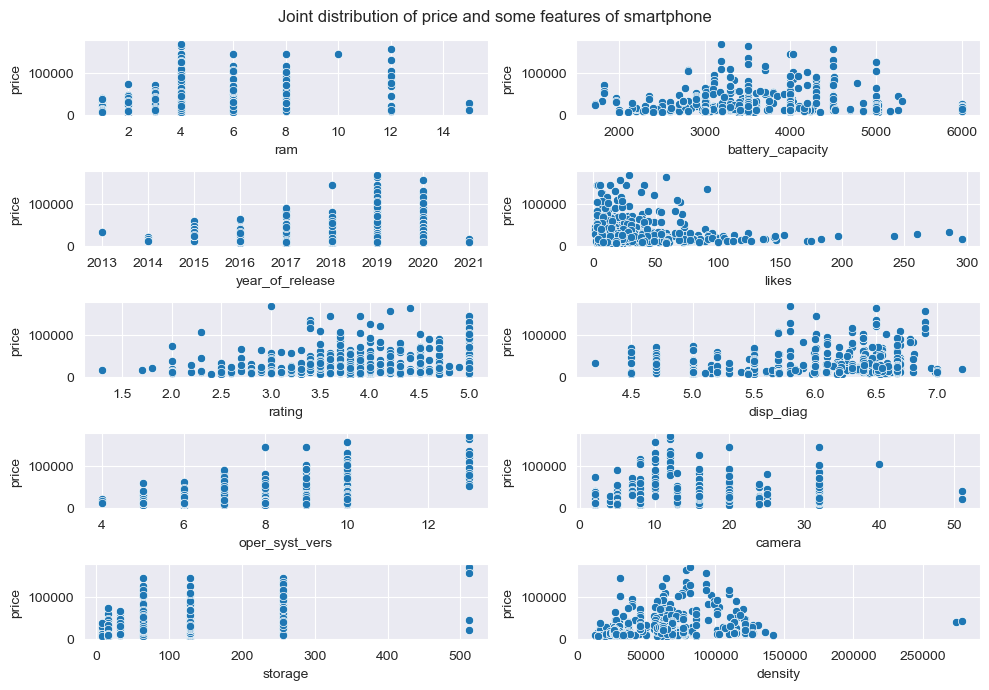

In [11]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of price and some features of smartphone')
plt.tight_layout();

Таким образом, явной линейной и логлинейной звисимости тут не прослеживается. Попробуем отлогарифмировать признаки.

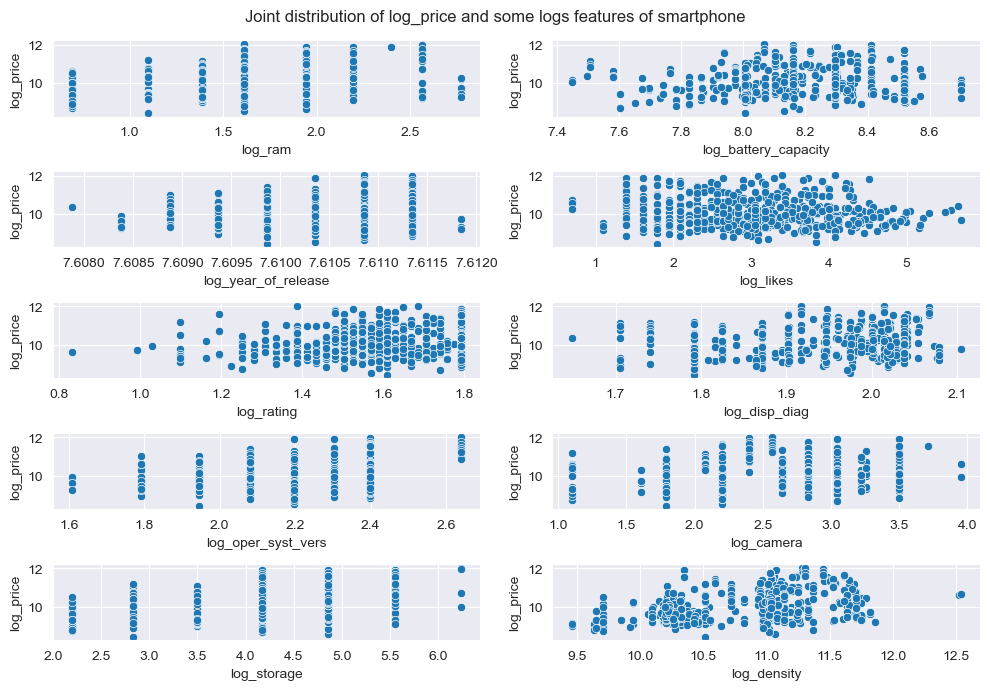

In [12]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.log_price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('log_price')
fig.suptitle('Joint distribution of log_price and some logs features of smartphone')
plt.tight_layout();

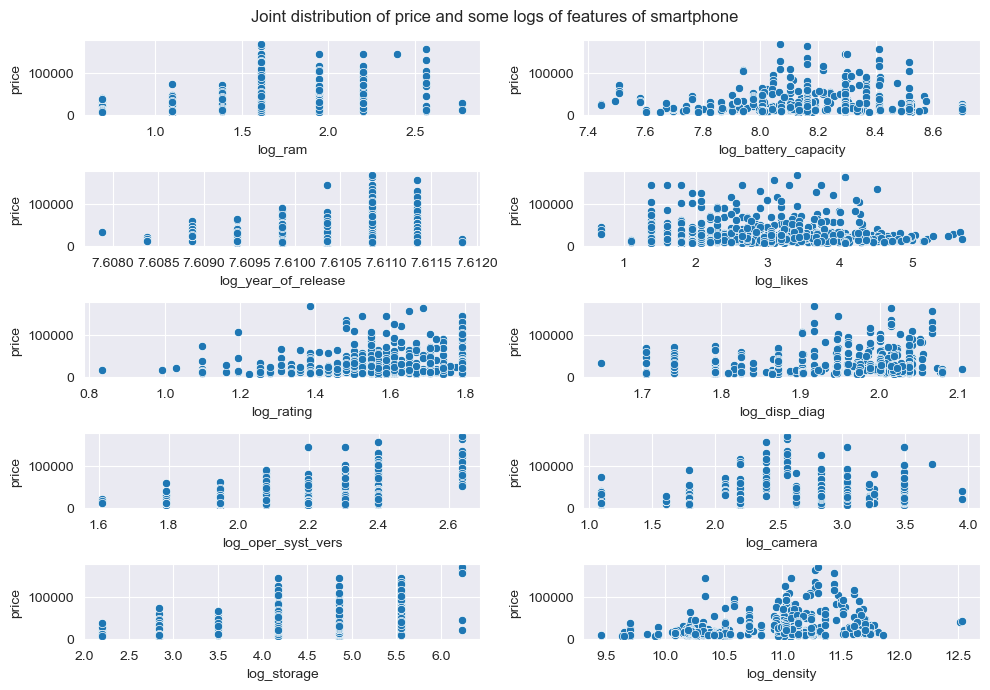

In [13]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('price')
fig.suptitle('Joint distribution of price and some logs of features of smartphone')
plt.tight_layout();

Явных зависимостей тоже не видно, но это всего лишь проекция данных на 2 оси, так что не стоит отчаиваться!

Посмотрим на корреляции 

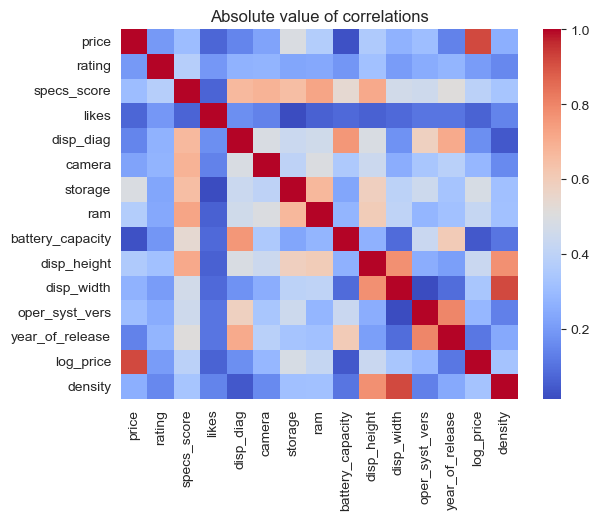

In [14]:
sns.heatmap(np.abs(data.corr()), cmap="coolwarm")
plt.title('Absolute value of correlations');

### 1. Обработка данных

In [15]:
data.sample(3)
data = data.drop(columns = ['price'])

In [16]:
def encode_and_bind(original_dataframe, feature_to_encode, drop = True):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    if drop == True:
        res = res.drop(columns = [feature_to_encode])
    return(res)

In [17]:
data = data.set_index('phone_title')

In [18]:
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type', 'likes'])

In [19]:
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand')

In [20]:
data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo'})

In [21]:
data.sample(3)

,rating,specs_score,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,oper_syst_vers,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
phone_title,,,,,,,,,,,,,,,,,,,,,
HTC One M9 Plus,3.9,63,5.20,4.0,32.0,3.0,2840.0,2560.0,1440.0,5,...,0,0,0,0,0,0,0,0,0,0
Xiaomi Mi 10 5G 12GB/256GB,3.7,100,6.67,20.0,256.0,12.0,4780.0,2340.0,1080.0,10,...,0,0,0,0,0,0,0,0,0,1
Honor 30 Youth 6GB/64GB,4.0,90,6.50,16.0,64.0,6.0,4000.0,2400.0,1080.0,10,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from scipy.stats import t
X_columns = data.drop(columns=['log_price', 'IOS_oper_syst', 'oper_syst_vers', 'disp_height', 'disp_width', 'specs_score']).columns

ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()

n = data.shape[0]
k = X_columns.shape[0] + 1
t_crit_r = t.ppf(0.975, n - k - 1)
t_crit_l = -t_crit_r
resid_std = ols.outlier_test()['student_resid']
mask = (resid_std < t_crit_r) & (resid_std > t_crit_l)

data = data[mask]

C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [23]:
data['brand_Hotwav'].unique()

array([0], dtype=uint8)

In [24]:
data = data.drop(columns = ['brand_Hotwav'])

### 2. EDA

In [25]:
np.round(data.describe(), 2)

,rating,specs_score,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,oper_syst_vers,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
count,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,...,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00
mean,3.84,66.67,6.01,13.05,83.18,4.46,3756.70,1969.14,986.75,8.44,...,0.01,0.04,0.03,0.05,0.03,0.18,0.02,0.08,0.01,0.15
std,0.75,21.26,0.59,8.65,77.04,2.56,864.52,555.54,277.86,1.62,...,0.10,0.19,0.17,0.23,0.18,0.39,0.15,0.27,0.09,0.36
min,1.30,28.00,4.20,2.00,8.00,1.00,1715.00,480.00,480.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.30,50.50,5.50,7.00,32.00,3.00,3020.00,1520.00,720.00,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.80,62.00,6.20,10.00,64.00,4.00,4000.00,1920.00,1080.00,9.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.40,88.00,6.50,16.00,128.00,6.00,4200.00,2340.00,1080.00,10.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,100.00,7.20,51.00,512.00,15.00,6000.00,3840.00,3840.00,13.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [26]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [27]:
mean_mode_median(data)

,Mode,Median,Mean
rating,5.00,3.80,3.84
specs_score,100.00,62.00,66.67
disp_diag,5.50,6.20,6.01
camera,8.00,10.00,13.05
storage,128.00,64.00,83.18
ram,4.00,4.00,4.46
battery_capacity,4000.00,4000.00,3756.70
disp_height,2340.00,1920.00,1969.14
disp_width,1080.00,1080.00,986.75
oper_syst_vers,9.00,9.00,8.44


### 3. Multicollinearity

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_m = add_constant(data)
data_m = data_m.drop(columns = ['log_price'])
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                 0.000000
rating                1.320944
specs_score           7.246615
disp_diag             9.521513
camera                2.163287
storage               2.723075
ram                   2.751572
battery_capacity      3.652083
disp_height          17.567822
disp_width           12.714238
oper_syst_vers       16.652925
year_of_release      12.878089
density              30.145354
Other_oper_syst       2.125065
IOS_oper_syst              inf
battery_type_LiPo     2.042732
brand_BlackBerry           inf
brand_Cubot                inf
brand_Gionee               inf
brand_Google               inf
brand_HTC                  inf
brand_Honor                inf
brand_Huawei               inf
brand_Infinix              inf
brand_LG                   inf
brand_Lava                 inf
brand_Lenovo               inf
brand_Motorola             inf
brand_Nokia                inf
brand_OnePlus              inf
brand_Oppo                 inf
brand_Realme               inf
brand_Sa

In [29]:
data_m = data_m.drop(columns = 'IOS_oper_syst')
data = data.drop(columns = 'IOS_oper_syst')

In [30]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.202268e+07
rating               1.320944e+00
specs_score          7.246615e+00
disp_diag            9.521513e+00
camera               2.163287e+00
storage              2.723075e+00
ram                  2.751572e+00
battery_capacity     3.652083e+00
disp_height          1.756782e+01
disp_width           1.271424e+01
oper_syst_vers       1.665292e+01
year_of_release      1.287809e+01
density              3.014535e+01
Other_oper_syst      2.125065e+00
battery_type_LiPo    2.042732e+00
brand_BlackBerry     3.900724e+00
brand_Cubot          2.231090e+00
brand_Gionee         1.554946e+00
brand_Google         2.788439e+00
brand_HTC            7.881984e+00
brand_Honor          2.226780e+00
brand_Huawei         1.477209e+01
brand_Infinix        9.471935e+00
brand_LG             4.253822e+00
brand_Lava           1.539336e+00
brand_Lenovo         3.909401e+00
brand_Motorola       2.338297e+00
brand_Nokia          5.823387e+00
brand_OnePlus        4.745204e+00
brand_Oppo    

In [31]:
data_m = data_m.drop(columns = ['disp_height', 'disp_width', 'specs_score'])
data_m['density'] = data['density']

data = data.drop(columns = ['disp_height', 'disp_width', 'specs_score'])

In [32]:
np.round(pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns), 2)


const                21906370.79
rating                      1.29
disp_diag                   4.92
camera                      1.72
storage                     2.42
ram                         2.44
battery_capacity            3.38
oper_syst_vers             16.41
year_of_release            12.81
density                     1.85
Other_oper_syst             2.10
battery_type_LiPo           1.94
brand_BlackBerry            3.80
brand_Cubot                 2.21
brand_Gionee                1.54
brand_Google                2.73
brand_HTC                   7.70
brand_Honor                 2.16
brand_Huawei               14.39
brand_Infinix               9.32
brand_LG                    4.14
brand_Lava                  1.53
brand_Lenovo                3.85
brand_Motorola              2.31
brand_Nokia                 5.72
brand_OnePlus               4.63
brand_Oppo                  8.18
brand_Realme                5.36
brand_Samsung              20.67
brand_Sony                  3.86
brand_Tecn

In [33]:
data_new = data_m.copy()
data_new.drop(columns='oper_syst_vers', inplace=True)
data.drop(columns='oper_syst_vers', inplace=True)

In [34]:
np.round(pd.Series([variance_inflation_factor(data_new.values, i) 
               for i in range(data_new.shape[1])], 
              index=data_new.columns), 2)


const                4866291.09
rating                     1.29
disp_diag                  4.62
camera                     1.70
storage                    2.41
ram                        2.44
battery_capacity           3.38
year_of_release            2.84
density                    1.85
Other_oper_syst            1.24
battery_type_LiPo          1.91
brand_BlackBerry           1.97
brand_Cubot                1.22
brand_Gionee               1.14
brand_Google               1.60
brand_HTC                  2.46
brand_Honor                1.30
brand_Huawei               4.01
brand_Infinix              2.87
brand_LG                   1.72
brand_Lava                 1.12
brand_Lenovo               1.61
brand_Motorola             1.31
brand_Nokia                2.09
brand_OnePlus              2.00
brand_Oppo                 2.63
brand_Realme               2.27
brand_Samsung              5.31
brand_Sony                 1.66
brand_Tecno                3.26
brand_Vivo                 1.35
brand_Xi

### 3. Heteroskedasticity

In [35]:
# X_columns = data.drop(columns = ['log_price', 'oper_syst_vers']).columns
X_columns = data_new.columns[1:]
print(' + '.join(map(str, X_columns)))


rating + disp_diag + camera + storage + ram + battery_capacity + year_of_release + density + Other_oper_syst + battery_type_LiPo + brand_BlackBerry + brand_Cubot + brand_Gionee + brand_Google + brand_HTC + brand_Honor + brand_Huawei + brand_Infinix + brand_LG + brand_Lava + brand_Lenovo + brand_Motorola + brand_Nokia + brand_OnePlus + brand_Oppo + brand_Realme + brand_Samsung + brand_Sony + brand_Tecno + brand_Vivo + brand_Xiaomi


In [36]:
ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     23.06
Date:                Tue, 09 May 2023   Prob (F-statistic):           1.64e-78
Time:                        01:33:00   Log-Likelihood:                -310.10
No. Observations:                 559   AIC:                             684.2
Df Residuals:                     527   BIC:                             822.6
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -60.3056     40.493     -1.489      0.137    -139.852      19.241
rating                0.0638      0.028      2.302      0.022       0.009       0.118
disp_diag             0.0135      0.067      0.200      0.842      -0.119       0.146
camera                0.0077      0.003      2.767      0.006       0.002       0.013
storage               0.0020      0.000      5.536      0.000       0.001       0.003
ram                   0.0563      0.011      5.029      0.000       0.034       0.078
battery_capacity  -5.432e-05   3.91e-05     -1.390      0.165      -0.000    2.25e-05
year_of_release       0.0349      0.020      1.731      0.084      -0.005       0.074
density            2.516e-06   8.32e-07      3.026      0.003    8.83e-07    4.15e-06
Other_oper_syst       0.2176      0.342      0.636      0.525      -0.454       0.889
battery_type_LiPo     0.0351      0.051      0.689      0.491      -0.065       0.135
brand_BlackBerry     -0.7937      0.178     -4.469      0.000      -1.143      -0.445
brand_Cubot          -0.6583      0.240     -2.739      0.006      -1.130      -0.186
brand_Gionee         -1.1144      0.329     -3.392      0.001      -1.760      -0.469
brand_Google         -0.3976      0.167     -2.378      0.018      -0.726      -0.069
brand_HTC            -0.9723      0.126     -7.728      0.000      -1.219      -0.725
brand_Honor          -0.2399      0.222     -1.080      0.280      -0.676       0.196
brand_Huawei         -1.0120      0.112     -9.055      0.000      -1.232      -0.792
brand_Infinix        -1.1260      0.128     -8.778      0.000      -1.378      -0.874
brand_LG             -0.5213      0.160     -3.260      0.001      -0.835      -0.207
brand_Lava           -1.6125      0.325     -4.964      0.000      -2.251      -0.974
brand_Lenovo         -0.9967      0.167     -5.952      0.000      -1.326      -0.668
brand_Motorola       -0.3271      0.204     -1.606      0.109      -0.727       0.073
brand_Nokia          -1.0861      0.136     -7.967      0.000      -1.354      -0.818
brand_OnePlus        -0.3521      0.156     -2.262      0.024      -0.658      -0.046
brand_Oppo           -1.0077      0.132     -7.629      0.000      -1.267      -0.748
brand_Realme         -1.0207      0.157     -6.519      0.000      -1.328      -0.713
brand_Samsung        -0.7934      0.110     -7.219      0.000      -1.009      -0.578
brand_Sony           -0.6052      0.163     -3.705      0.000      -0.926      -0.284
brand_Tecno          -0.9347      0.124     -7.512      0.000      -1.179      -0.690
brand_Vivo           -0.8305      0.227     -3.661      0.000      -1.276      -0.385
brand_Xiaomi         -0.9736      0.115     -8.449      0.000      -1.200      -0.747
=========================================================================

In [37]:
hat_log_price = ols.fittedvalues


C:\Users\Alexandr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


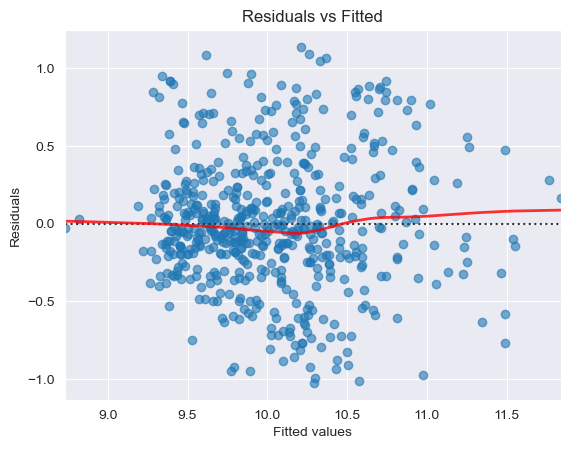

In [38]:
fig_1 = plt.figure(1)
fig_1.axes[0] = sns.residplot(hat_log_price, data['log_price'],
                                  lowess=True,
                                  scatter_kws={'alpha': 0.6},
                                  line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
fig_1.axes[0].set_title('Residuals vs Fitted')
fig_1.axes[0].set_xlabel('Fitted values')
fig_1.axes[0].set_ylabel('Residuals')
plt.show()

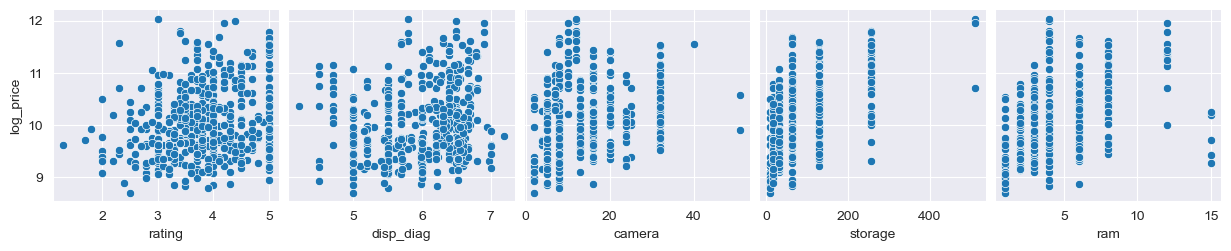

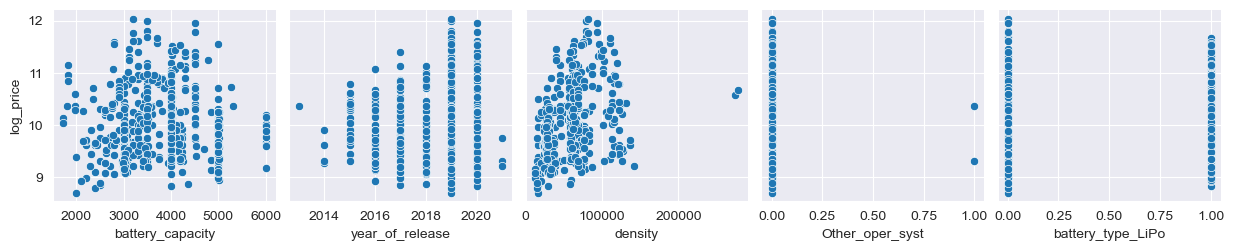

In [39]:
sns.pairplot(data, x_vars=X_columns[0:5], y_vars=["log_price"])
sns.pairplot(data, x_vars=X_columns[5:10], y_vars=["log_price"])
# sns.pairplot(data, x_vars=X_columns[10:15], y_vars=["log_price"]) # Неинтерпретируемые графики
# sns.pairplot(data, x_vars=X_columns[15:20], y_vars=["log_price"]) # Неинтерпретируемые графики
plt.show()

#### 3.1 Тест на проверку гетероскедостичности

$$\begin{align}
&H0: \sigma_{i}^2  = \sigma^2, \forall \ i \in \ \{0,1,2,3,4,5\} \ (гомоскедостичность) \\
&H1: \exists \ i, j : \sigma_{i}^2  \neq \sigma_{k}^2 \ (гетероскедостичность)
\end{align}$$

#### 3.1.1 Тест Уйата

In [40]:
X = data.loc[:, X_columns].copy()
y = data['log_price']
model = sm.OLS(y, X).fit()


In [41]:
white_test = het_white(model.resid,  model.model.exog)


In [42]:
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_white = dict(zip(labels, white_test))
print(f"Chi^2 observed statistic: {res_white['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}") Проверить док
print(f"P-value = {res_white['Chi^2 obserrved statistic p-value']}")

Chi^2 observed statistic: 298.8938272606279
P-value = 3.760080082074024e-06


Нулевая гипотеза о гомоскедостичности остатков отвергается на любом разумном уровне значимости

#### 3.1.2 Бройша-Пагана

In [43]:
bp_test = het_breuschpagan(model.resid,  model.model.exog)
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_bp = dict(zip(labels, bp_test))
print(f"Chi^2 observed statistic: {res_bp['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}")  Проверить док
print(f"P-value = {res_bp['Chi^2 obserrved statistic p-value']}")


Chi^2 observed statistic: 265.29320050510654
P-value = 1.650698893511396e-39


#### 3.1.3 Тест Голдфелда — Куандта

In [44]:
goldfeldquandt = het_goldfeldquandt(model.resid,  model.model.exog)
labels = ['F-statistics observed', 'F-statistics p-value', 'ordering']
res_goldfeldquandt = dict(zip(labels, goldfeldquandt))
print(f"F observed statistic: {res_goldfeldquandt['F-statistics observed']}")
print(f"P-value = {res_goldfeldquandt['F-statistics p-value']}")



F observed statistic: 1.168091499287371
P-value = 0.10767605749189496


### 3.2 Решение проблемы гетероскедостичности

Для решение этой проблемы воспользуюсь робастными оценками в форме Уайта

##### 3.2.1 Общая информации модели до применение робастных оценок

In [45]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     23.06
Date:                Tue, 09 May 2023   Prob (F-statistic):           1.64e-78
Time:                        01:33:03   Log-Likelihood:                -310.10
No. Observations:                 559   AIC:                             684.2
Df Residuals:                     527   BIC:                             822.6
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -60.3056     40.493     -1.489      0.137    -139.852      19.241
rating                0.0638      0.028      2.302      0.022       0.009       0.118
disp_diag             0.0135      0.067      0.200      0.842      -0.119       0.146
camera                0.0077      0.003      2.767      0.006       0.002       0.013
storage               0.0020      0.000      5.536      0.000       0.001       0.003
ram                   0.0563      0.011      5.029      0.000       0.034       0.078
battery_capacity  -5.432e-05   3.91e-05     -1.390      0.165      -0.000    2.25e-05
year_of_release       0.0349      0.020      1.731      0.084      -0.005       0.074
density            2.516e-06   8.32e-07      3.026      0.003    8.83e-07    4.15e-06
Other_oper_syst       0.2176      0.342      0.636      0.525      -0.454       0.889
battery_type_LiPo     0.0351      0.051      0.689      0.491      -0.065       0.135
brand_BlackBerry     -0.7937      0.178     -4.469      0.000      -1.143      -0.445
brand_Cubot          -0.6583      0.240     -2.739      0.006      -1.130      -0.186
brand_Gionee         -1.1144      0.329     -3.392      0.001      -1.760      -0.469
brand_Google         -0.3976      0.167     -2.378      0.018      -0.726      -0.069
brand_HTC            -0.9723      0.126     -7.728      0.000      -1.219      -0.725
brand_Honor          -0.2399      0.222     -1.080      0.280      -0.676       0.196
brand_Huawei         -1.0120      0.112     -9.055      0.000      -1.232      -0.792
brand_Infinix        -1.1260      0.128     -8.778      0.000      -1.378      -0.874
brand_LG             -0.5213      0.160     -3.260      0.001      -0.835      -0.207
brand_Lava           -1.6125      0.325     -4.964      0.000      -2.251      -0.974
brand_Lenovo         -0.9967      0.167     -5.952      0.000      -1.326      -0.668
brand_Motorola       -0.3271      0.204     -1.606      0.109      -0.727       0.073
brand_Nokia          -1.0861      0.136     -7.967      0.000      -1.354      -0.818
brand_OnePlus        -0.3521      0.156     -2.262      0.024      -0.658      -0.046
brand_Oppo           -1.0077      0.132     -7.629      0.000      -1.267      -0.748
brand_Realme         -1.0207      0.157     -6.519      0.000      -1.328      -0.713
brand_Samsung        -0.7934      0.110     -7.219      0.000      -1.009      -0.578
brand_Sony           -0.6052      0.163     -3.705      0.000      -0.926      -0.284
brand_Tecno          -0.9347      0.124     -7.512      0.000      -1.179      -0.690
brand_Vivo           -0.8305      0.227     -3.661      0.000      -1.276      -0.385
brand_Xiaomi         -0.9736      0.115     -8.449      0.000      -1.200      -0.747
=========================================================================

##### 3.2.2 Применение робастных оценок

In [46]:
ols_robust = ols.get_robustcov_results()
ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     99.65
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.35e-198
Time:                        01:33:03   Log-Likelihood:                -310.10
No. Observations:                 559   AIC:                             684.2
Df Residuals:                     527   BIC:                             822.6
Df Model:                          31                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -60.3056     40.394     -1.493      0.136    -139.659      19.048
rating                0.0638      0.029      2.233      0.026       0.008       0.120
disp_diag             0.0135      0.069      0.196      0.845      -0.122       0.149
camera                0.0077      0.003      2.623      0.009       0.002       0.013
storage               0.0020      0.000      4.480      0.000       0.001       0.003
ram                   0.0563      0.014      4.088      0.000       0.029       0.083
battery_capacity  -5.432e-05   4.03e-05     -1.349      0.178      -0.000    2.48e-05
year_of_release       0.0349      0.020      1.737      0.083      -0.005       0.074
density            2.516e-06   8.24e-07      3.053      0.002    8.97e-07    4.14e-06
Other_oper_syst       0.2176      0.451      0.482      0.630      -0.669       1.104
battery_type_LiPo     0.0351      0.054      0.657      0.512      -0.070       0.140
brand_BlackBerry     -0.7937      0.228     -3.476      0.001      -1.242      -0.345
brand_Cubot          -0.6583      0.117     -5.612      0.000      -0.889      -0.428
brand_Gionee         -1.1144      0.145     -7.673      0.000      -1.400      -0.829
brand_Google         -0.3976      0.268     -1.486      0.138      -0.923       0.128
brand_HTC            -0.9723      0.124     -7.817      0.000      -1.217      -0.728
brand_Honor          -0.2399      0.195     -1.227      0.220      -0.624       0.144
brand_Huawei         -1.0120      0.111     -9.103      0.000      -1.230      -0.794
brand_Infinix        -1.1260      0.120     -9.389      0.000      -1.362      -0.890
brand_LG             -0.5213      0.176     -2.962      0.003      -0.867      -0.176
brand_Lava           -1.6125      0.108    -14.884      0.000      -1.825      -1.400
brand_Lenovo         -0.9967      0.121     -8.251      0.000      -1.234      -0.759
brand_Motorola       -0.3271      0.208     -1.570      0.117      -0.736       0.082
brand_Nokia          -1.0861      0.119     -9.091      0.000      -1.321      -0.851
brand_OnePlus        -0.3521      0.130     -2.711      0.007      -0.607      -0.097
brand_Oppo           -1.0077      0.132     -7.662      0.000      -1.266      -0.749
brand_Realme         -1.0207      0.150     -6.810      0.000      -1.315      -0.726
brand_Samsung        -0.7934      0.115     -6.891      0.000      -1.020      -0.567
brand_Sony           -0.6052      0.171     -3.546      0.000      -0.941      -0.270
brand_Tecno          -0.9347      0.130     -7.217      0.000      -1.189      -0.680
brand_Vivo           -0.8305      0.119     -6.969      0.000      -1.065      -0.596
brand_Xiaomi         -0.9736      0.122     -7.979      0.000      -1.213      -0.734
=========================================================================

### 4. Спецификация модели

In [47]:
rams = reset_ramsey(ols_robust, degree = 2)
print(f"{rams.summary().split(', ')[0][-19:]}")
print(f"{rams.summary().split(', ')[1]}")

F=2.743483985320529
p=0.09824801830567333


In [48]:
rams = reset_ramsey(ols_robust, degree = 3)
print(f"{rams.summary().split(', ')[0][-19:]}")
print(f"{rams.summary().split(', ')[1]}")

F=3.485591761803363
p=0.031346489975819916


In [49]:
rams = reset_ramsey(ols_robust, degree = 4)
print(f"{rams.summary().split(', ')[0][-20:]}")
print(f"{rams.summary().split(', ')[1]}")

F=2.4818926274297155
p=0.060175859516580506


Нулевая гипотеза не отвергается на уровне значимости 1% для любых степеней, следовательно гипотеза о том, что модель правильно специфицирована не отвергается.

### 5. Функциональная форма

#### 1. PE-тест

In [129]:
Lin_data = data.copy()
Lin_data['price'] = np.exp(Lin_data['log_price'])
Lin_data = Lin_data.drop(columns = ['log_price'])

Log_data = data.copy()

In [130]:
Lin_data.columns

Index(['rating', 'disp_diag', 'camera', 'storage', 'ram', 'battery_capacity',
       'year_of_release', 'density', 'Other_oper_syst', 'battery_type_LiPo',
       'brand_BlackBerry', 'brand_Cubot', 'brand_Gionee', 'brand_Google',
       'brand_HTC', 'brand_Honor', 'brand_Huawei', 'brand_Infinix', 'brand_LG',
       'brand_Lava', 'brand_Lenovo', 'brand_Motorola', 'brand_Nokia',
       'brand_OnePlus', 'brand_Oppo', 'brand_Realme', 'brand_Samsung',
       'brand_Sony', 'brand_Tecno', 'brand_Vivo', 'brand_Xiaomi', 'price'],
      dtype='object')

In [131]:
lin_model = sm.OLS(Lin_data['price'], Lin_data.drop(columns = ['price'])).fit()
y_lin_hat = lin_model.predict(Lin_data.drop(columns = ['price']))

In [132]:
log_model = sm.OLS(Log_data['log_price'], Log_data.drop(columns = ['log_price'])).fit()
y_log_hat = log_model.predict(Log_data.drop(columns = ['log_price']))

In [133]:
Lin_data['log_part'] = y_log_hat - np.log(y_lin_hat)
Log_data['lin_part'] = y_lin_hat - np.exp(y_log_hat)

In [134]:
lin_logpart_model = sm.OLS(Lin_data['price'], Lin_data.drop(columns = ['price'])).fit()
lin_logpart_model = lin_logpart_model.get_robustcov_results()

log_linpart_model = sm.OLS(Log_data['log_price'], Log_data.drop(columns = ['log_price'])).fit()
log_linpart_model = log_linpart_model.get_robustcov_results()


In [135]:
# print(f"P-value log_part in lin_logpart_model = {lin_logpart_model.pvalues['log_part']}") # sigma_lin
# print(f"P-value lin_part in log_linpart_model = {log_linpart_model.pvalues['lin_part']}") # sigma_log

In [136]:
print(f"P-value log_part in lin_logpart_model = {lin_logpart_model.pvalues[-1]}") # sigma_lin
print(f"P-value lin_part in log_linpart_model = {log_linpart_model.pvalues[-1]}") # sigma_log

P-value log_part in lin_logpart_model = 1.5048094817103705e-07
P-value lin_part in log_linpart_model = 0.5171589650377625


На любом разумном уровне значимости нулевая гипотеза о незначимости логорифмической части в линейной модели отвергается, то есть sigma_lin значим. В то же время значимость линейней части в полулогорифмической модели отвергается при любом разумном уровне значимости, то есть не отвергается гипотеза, что sigma_log = 0. Другими словами, линейная часть в полулогорифмической модели не позволило лучше объяснить данные, в то время как логорифмическая чать в линейной модели значительно показало значимый результат.

Следовательно относительно PE-теста необходимо выбрать полулогорифмическую модель.

#### 5.1 Проверка нормальности остатков (Тест Харке-Бера)

In [140]:
_, p_value = stats.jarque_bera(ols_robust.resid)
print(f"Тест Харке-Бера p_value = {p_value}") #

Тест Харке-Бера p_value = 0.07502183295553588


На 10% уровне значимости нулевая гипотеза, что остатки имеют нормальное распределение, не отвергается. Следовательно, так как остатки являются оценкой ошибок, то не отвергается, что выполняется предпосылка КЛММР о нормальной распределенности ошибок.